In [1]:
from pathlib import Path
import os
import json
import sys
import optuna
from optuna.samplers import TPESampler
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback
import numpy as np
import torch
import random
import yaml
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
path_to_src = Path(Path(os.getcwd()).parent, 'src')
sys.path.append(str(path_to_src))
from enviroment import StockTradingEnvDSR
from agents import LinearFeatureExtractor, RNNFeatureExtractor, LSTMExtractor, MLPFeatureExtractor
from utils import get_data, get_scaled_data_new, get_time_data_new, prepare_aligned_data, daily_portfolio_return, statistics_calc
from optimization_DQN import set_seeds, train_model, objective_dqn, create_env
from optimization_PPO import train_single_model, sliding_window_training, optimize_config
import warnings
warnings.filterwarnings('ignore')

# Reinforcement Learning (RL) in algorithmic trading

In supervised learning (Supervised learning) we want to predict a target (target) using a set of features (predictors), and we train an ML model using a set of sample pairs (features, label). In reinforcement learning (RL) we want to maximize an objective using a sequence of actions (hence it is sometimes called "sequential decision making"). Each action $a(t)$ at time $t$ is based on state variables $s(t)$ at time $t$, and the next state $s(t+1)$ may (but not necessarily) depend on $s(t)$ and $a(t)$. In general, both $a$ and $s$ can be vectors or even matrices. State variables in RL correspond to features in supervised learning. After the action $a(t)$ is executed, we receive a reward $r(t)$, a scalar. In the simplest case (e.g., in the example we consider) the ultimate goal is to maximize the expected total reward:
$$J = E[r(0) + r(1) + ... + r(T)]$$
The ML model in deep reinforcement learning (DRL) is used to learn from the sequence $(s(t), a(t), r(t))$ for $t=0, 1, 2, \dots,$ to generate optimal $a(t)$ given input $s(t)$, with the goal of maximizing $J$. In theory, it is standard to call this ML model a policy $\pi$. Importantly, $\pi$ is a probability distribution over actions conditioned on states, $\pi( a(t) | s(t) )$. The action is not a deterministic function of the state. This is why the goal of DRL is to maximize the expected total reward, not the realized total reward from a single sampled sequence $(s(t), a(t), r(t))$.
$$
\pi^* = \text{argmax}_\pi J(\pi) = \text{argmax}_\pi \mathbb{E} \left[ \sum_{t=0}^T r(s_t, a_t \sim \pi(a|s_t)) \right] \tag{1}
$$

where $\sim$ means that action $a$ is sampled from the probability distribution $\pi(a(t)|s(t))$. To simplify notation, we used $s$ and $a$ to denote $s(t)$ and $a(t)$.

### Q-learning

Q-learning is a reinforcement learning (RL) algorithm where the agent learns an **optimal policy** through estimation of the action-value function. Key concepts:

- **Q-function** $Q(s,a)$: Expected cumulative discounted reward for choosing action $a$ in state $s$ followed by optimal policy
- **V-function** $V(s)$: Expected cumulative reward from state $s$ under optimal policy ($V(s) = \max_a Q(s,a)$)
- **Q-V relationship**: $Q(s,a) = r(s,a) + \gamma \mathbb{E}[V(s')]$
  
$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right) \tag{1}
$$

where:
- $\alpha$ – learning rate
- $\gamma$ – discount factor
- $r_t$ – reward at step $t$

Uses $\epsilon$-greedy exploration strategy:
- With probability $\epsilon$ select random action
- Otherwise select action $\underset{a}{\operatorname{arg\,max}} Q(s_t, a)$

Total future reward is defined as:

$$
R_\Sigma = r_t + \gamma V(s_{t+1}) \tag{2}
$$

Generalization to $n$ steps (n-step return):

$$
R_\Sigma^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n \max_a Q(s_{t+n}, a) \tag{3}
$$

When parameterizing Q-function with neural network $Q_\theta$ we get:

$$
Q_\theta(s_t, a_t) \leftarrow Q_\theta(s_t, a_t) + \alpha \left( R_\Sigma^{(n)} - Q_\theta(s_t, a_t) \right) \tag{4}
$$

where target value is computed as:

$$
R_\Sigma^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n \max_a Q_{\theta^-}(s_{t+n}, a) \tag{5}
$$

Here $\theta^-$ are target network parameters.

### Proximal Policy Optimization (PPO)

#### 1. Policy update via gradient descent  
In Reinforcement Learning the goal is to maximize the agent's cumulative reward. Direct optimization of policy parameters  
$
\pi_\theta(a \mid s)
$
using gradient descent can lead to overly drastic strategy changes and destabilize learning.

---

#### 2. Probability Ratio  
To measure how much the new policy differs from the old, the probability ratio is introduced:
$$
r(\theta) = \frac{\pi_\theta(a \mid s)}{\pi_{\theta_\text{old}}(a \mid s)}
$$
- If $r(\theta)$ deviates significantly from 1, the new policy is too far from the previous one.  
- Controlling "aggressive" updates helps maintain training stability.

---

#### 3. Advantage Estimate  
Advantage $A_t$ shows how much an action exceeded expectations:
$$
A_t = R_t - V(s_t)
$$ 
- $R_t$ – cumulative discounted reward from time $t$.  
- $V(s_t)$ – state-value estimate of $s_t$.  
- $A_t>0$ indicates better-than-average actions, $A_t<0$ – worse.

---

#### 4. Clipping mechanism  
To prevent overly large steps, "clipping" of the ratio is used:
$$
L(\theta) = \mathbb{E}\bigl[\min\bigl(r(\theta)\,A_t,\;\mathrm{clip}\bigl(r(\theta),\,1-\varepsilon,\,1+\varepsilon\bigr)\,A_t\bigr)\bigr]
$$  
- $\varepsilon\in[0.1,0.3]$ sets the acceptable range for $r(\theta)$ changes.  
- If $r(\theta)$ exceeds $[1-\varepsilon,\,1+\varepsilon]$, it signals "too drastic" an update and its contribution to the loss is limited.

---

#### 5. Final PPO training process  
1. **Collect trajectories** using current policy $\pi_{\theta_\text{old}}$.  
2. **Estimate advantages** $A_t$ using value function $V(s)$.  
3. **Optimize** updated policy $\pi_\theta$ with loss $L(\theta)$ and clipping mechanism.  
4. **Update** old parameters: $\theta_\text{old}\gets\theta$.  
5. **Repeat cycle** until convergence.


### Used algorithms and models

In my implementation I relied on ready-to-use implementations from [Stable Baselines 3](https://github.com/DLR-RM/stable-baselines3) library:

- **DQN**  
- **PPO**

#### Code repository  
All environment and agent files are available at:  
> https://github.com/VladShchekotikhin/rl_study

---

#### Q-function parameterization in DQN

For DQN, three different feature extractors were considered, each defining its own $Q(s,a)$ approximation architecture:

1. **LinearFeatureExtractor**  
   - Convolves entire observation window into vector of length `features_dim`.  
   - Consists of one linear layer + Tanh activation.  
2. **RNNFeatureExtractor**
   - Consists of one recurrent layer $\text{RNN}$ and one linear layer.
   - Due to its recurrent structure, should better capture temporal dependencies.
3. **LSTMExtractor**
   - Consists of one recurrent layer $\text{LSTM}$ and one linear layer.
   - Due to its recurrent structure, should better capture temporal dependencies.

### Reward function: Differential Sharpe Ratio (DSR)

In algorithmic trading tasks, standard profit maximization often leads to suboptimal results because it does not account for risk. Modern portfolio managers maximize risk-adjusted returns. For this purpose, the Sharpe ratio is commonly used, but it has a limitation: it requires computation over a fixed time period $T$, which makes it unsuitable for online learning.

As a solution we use the Differential Sharpe Ratio (Differential Sharpe Ratio, DSR) (Moody et al., 1998). This metric allows evaluating risk-adjusted return at each time step $t$ and has proven effective in portfolio optimization tasks (Moody and Saffell, 2001; Dempster and Leemans, 2006).

#### Mathematical foundation

The standard Sharpe ratio over period $t$:
$$
S_t = \frac{A_t}{K_t \sqrt{B_t - A_t^2}}
$$
- $A_t = \frac{1}{t}\sum_{i=1}^{t} R_i$ (mean return)  
- $B_t = \frac{1}{t}\sum_{i=1}^{t} R_i^2$ (mean squared return)  
- $K_t = \sqrt{\frac{t}{t-1}}$ (normalizing factor)

For online learning we switch to an exponential moving average with update rate parameter $\eta \approx \frac{1}{252}$ (252 trading days in a year):
$$
A_t = A_{t-1} + \eta \Delta A_t 
$$
$$
B_t = B_{t-1} + \eta \Delta B_t 
$$
with updates:
$$
\Delta A_t = R_t - A_{t-1} 
$$
$$
\Delta B_t = R_t^2 - B_{t-1} 
$$
(initialization: $A_0 = B_0 = 0$)

Expanding $S_t$ in a Taylor series to first order:
$$
S_t \approx S_{t-1} + \eta \left. \frac{\partial S_t}{\partial \eta} \right|_{\eta=0} + O(\eta^2) 
$$
we obtain the reward at step $t$:
$$
D_t \equiv \frac{\partial S_t}{\partial \eta} = \frac{B_{t-1} \Delta A_t - \frac{1}{2} A_{t-1} \Delta B_t}{(B_{t-1} - A_{t-1}^2)^{3/2}}
$$

# DQN testing

In [2]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-11-13", "2024-01-11"),
    "val_period": ("2024-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 7200,  # 1 час
        "direction": "maximize"
    }
}

Trading once a day:

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_10


Output()

Обучение завершено


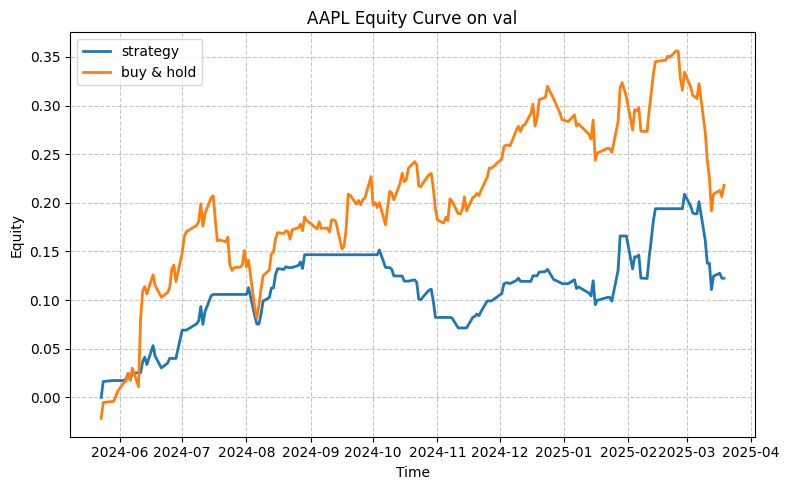

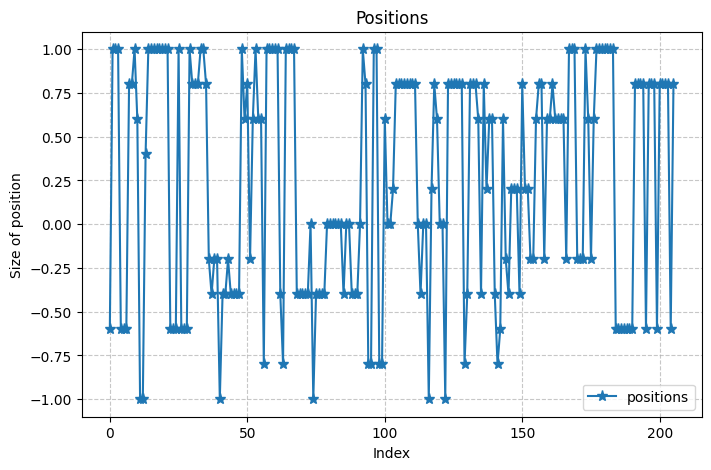

Metrics on val:
Sharpe ratio: 1.2799, annual return: 0.2294, volatility: 0.1792


In [3]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Training the final model with the best parameters
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["window_size"] = best_params["window_size"]
    del best_params["window_size"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Simple learning without optimization
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')


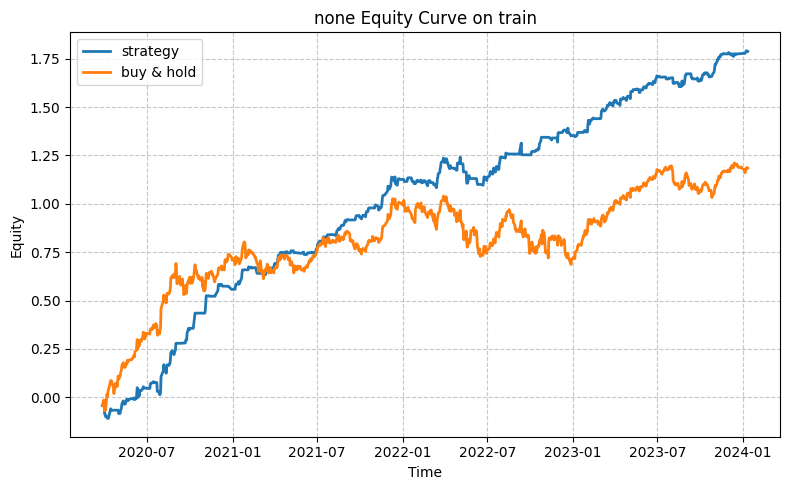

Metrics on train:
Sharpe ratio: 3.3767, annual return: 0.7099, volatility: 0.2102


In [7]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h, _ = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True, mode='train')

Now we will increase the number of training steps to 1_000_000, and we will now trade on 5-minute bars.

Shape of data: (1628131, 6) 2010-01-04 14:30:00 2025-06-27 20:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_11


Output()

Обучение завершено


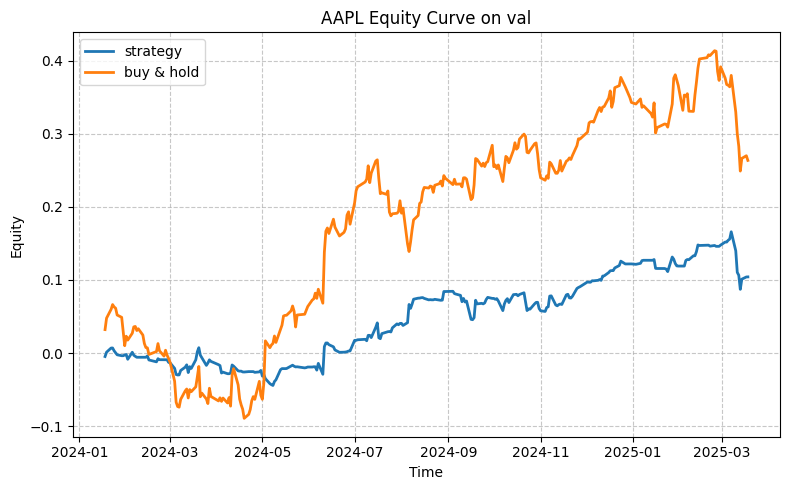

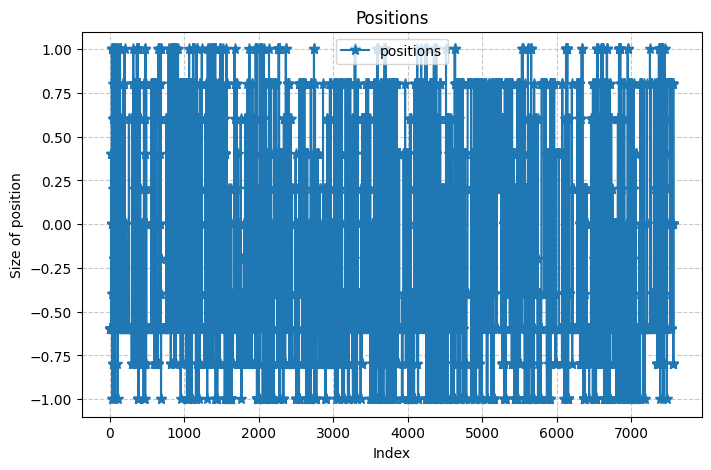

Metrics on val:
Sharpe ratio: 1.0844, annual return: 0.1358, volatility: 0.1252


In [8]:
metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG, interval='5min')

# PPO testing

In [2]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 50000,
    # Single-player periods
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None,  # Для одиночного режима
    "optuna": {
        "n_trials": 0,
        "timeout": 72000,  
        "direction": "maximize"
    }
}


In [3]:
def objective_ppo(trial):
    """Target function for optimizing hyperparameters"""
    config = CONFIG.copy()
    config["window_size"] = trial.suggest_categorical("window_size", [30, 60, 90, 120, 200])
    config["num_actions"] = trial.suggest_categorical("num_actions", [3, 5, 11, 19, 27])
    config["total_timesteps"] = trial.suggest_categorical("total_timesteps", [30000, 50000, 100000])
    config["ppo_params"]["n_steps"] = trial.suggest_int("n_steps", 128, 2048, step=128)
    # Batch size for training (must be divisible by n_steps)
    config["ppo_params"]["batch_size"] = trial.suggest_categorical("batch_size", [64, 128, 256, 512, 1024, 2048])
    # Number of passes (epochs) over the collected batch
    config["ppo_params"]["n_epochs"] = trial.suggest_int("n_epochs", 3, 30)
    # Discount factor
    config["ppo_params"]["gamma"] = trial.suggest_float("gamma", 0.90, 0.9999, step=0.001)
    # Lambda for GAE
    config["ppo_params"]["gae_lambda"] = trial.suggest_float("gae_lambda", 0.8, 1.0, step=0.01)
    # Range of “clipping” probabilities
    config["ppo_params"]["clip_range"] = trial.suggest_float("clip_range", 0.1, 0.4, step=0.05)
    # Learning rate
    config["ppo_params"]["learning_rate"] = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    # Entropy Bonus Coefficient
    config["ppo_params"]["ent_coef"] = trial.suggest_loguniform("ent_coef", 1e-5, 1e-1)
    # Loss factor of the value function
    config["ppo_params"]["vf_coef"] = trial.suggest_float("vf_coef", 0.1, 1.0, step=0.1)
    # Maximum gradient rate
    config["ppo_params"]["max_grad_norm"] = trial.suggest_float("max_grad_norm", 0.1, 1.0)
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
                                                                
    min_acceptable_return = 0.05
    all_results = sliding_window_training(config, trial=trial)
    annual_return = all_results["Annual return"].mean()
    sharpe = all_results["Sharpe ratio"].mean()
    vol = all_results["Volatility"].mean()
    if annual_return < min_acceptable_return:
        return annual_return - 1.0
    return 0.7 * all_results["Sharpe ratio"].mean() + 0.3 * all_results["Annual return"].mean() - 0.1 * vol

In [4]:
set_seeds(CONFIG["seed"])
Path("save", "models").parent.mkdir(exist_ok=True)
Path("save", "logs").parent.mkdir(exist_ok=True)

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
Logging to logs/PPO_3196


Output()

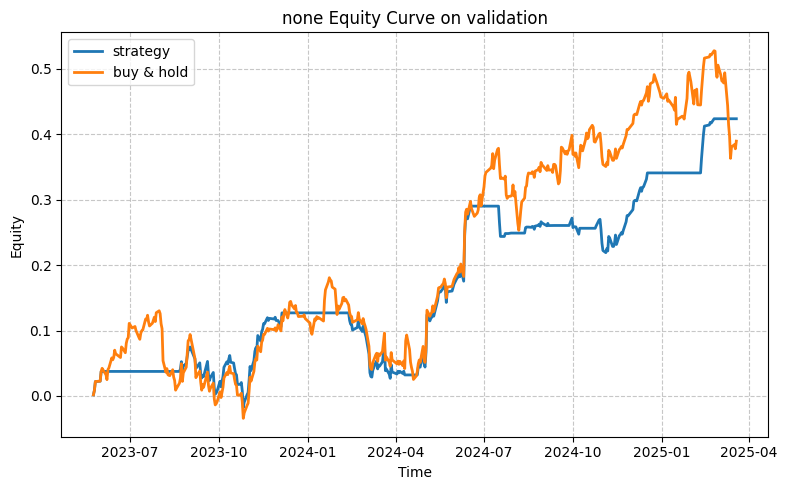

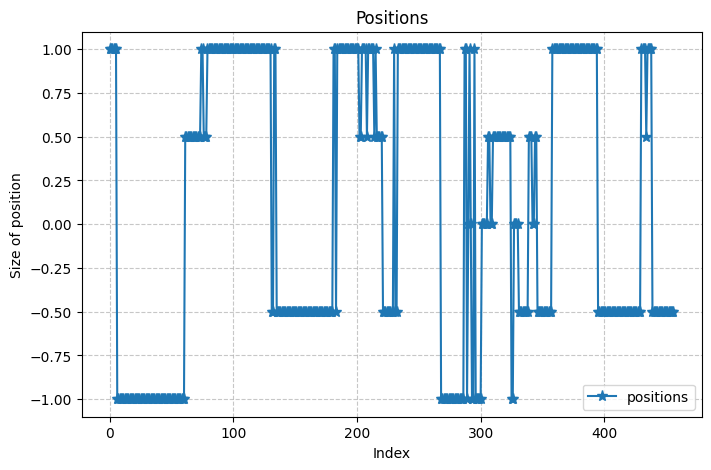

Metrics on validation:
Sharpe ratio: 2.1056, annual return: 0.3551, volatility: 0.1686


In [5]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Hyperparameter Optimization with Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective_ppo,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Best parameters: {best_params}")
    print(f"Best reward: {study.best_value}")
else:
    # Simple learning without optimization
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)

Shape of data: (1628131, 6) 2010-01-04 14:30:00 2025-06-27 20:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
Logging to logs/PPO_3197


Output()

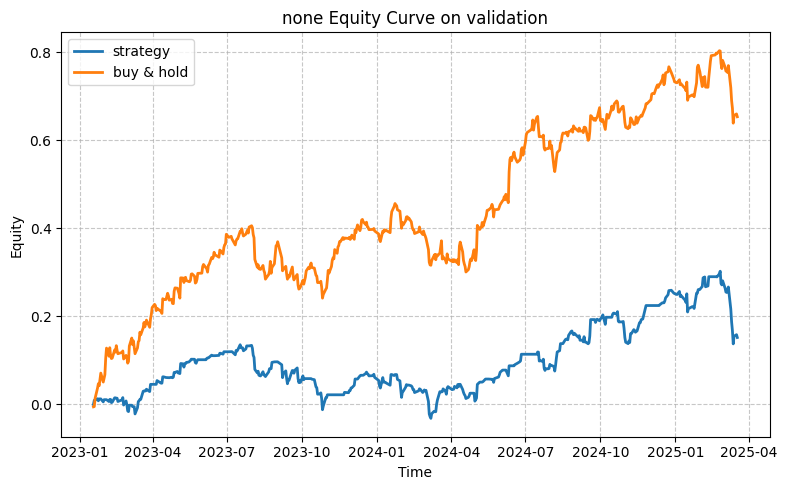

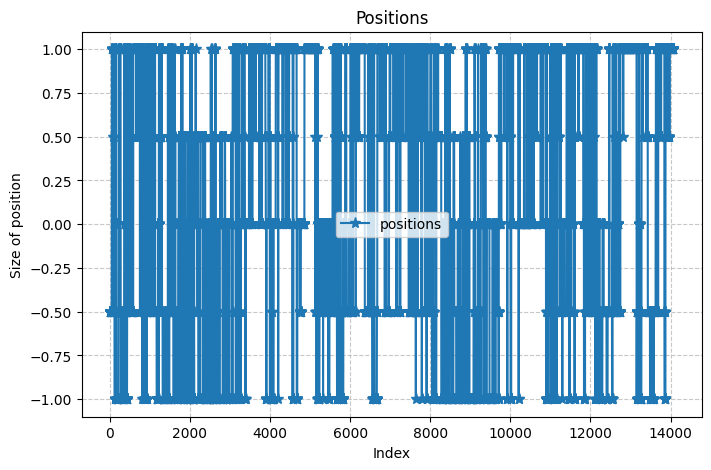

Metrics on validation:
Sharpe ratio: 0.6378, annual return: 0.1067, volatility: 0.1673


In [6]:
metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG, interval='5min')

# Подбор гиперпараметров

In the article [Deep Reinforcement Learning for Optimal Portfolio Allocation: A Comparative
Study with Mean-Variance Optimization](https://icaps23.icaps-conference.org/papers/finplan/FinPlan23_paper_4.pdf), where a detailed selection of PPO model parameters was made. Here is the resulting set from the article:
- "n_steps": 756
- "batch_size": 1260
- "n_epochs": 16
- "gamma": 0.9
- "gae_lambda": 0.9
- "clip_range": 0.25
- "learning_rate": 3e-4
- "ent_coef": 0.01
- "vf_coef": 0.5
- "max_grad_norm": 0.5

That article solved the problem of portfolio optimization, but we are considering a single asset, so it is worth conducting an independent selection of hyperparameters.

In [3]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 50000,
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None,  # Для одиночного режима
    "optuna": {
        "n_trials": 10,
        "timeout": 72000,  
        "direction": "maximize"
    }
}


In [ ]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Hyperparameter Optimization with Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective_ppo,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Best parameters: {best_params}")
    print(f"Best reward: {study.best_value}")
else:
    # Simple learning without optimization
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)

In [3]:
def update_config(old_dct, new_dct):
    for key, value in old_dct.items():
        if key in new_dct:
            old_dct[key] = new_dct[key]
        else:
            if isinstance(value, dict):
                update_config(value, new_dct)

In [41]:
update_config(CONFIG, best_params)
print(CONFIG)

{'ticker': 'AAPL', 'model_type': 'Linear', 'window_size': 120, 'price_column': 3, 'num_actions': 3, 'training_mode': 'single', 'sliding_window_config': {'train_years': 5, 'val_years': 1, 'test_years': 1, 'start_year': 2010, 'n_windows': 5, 'n_envs': 1, 'n_agents': 3}, 'seed': 42, 'ppo_params': {'n_steps': 1280, 'batch_size': 128, 'n_epochs': 30, 'gamma': 0.9440000000000001, 'gae_lambda': 0.9400000000000001, 'clip_range': 0.30000000000000004, 'learning_rate': 4.6149277258891906e-05, 'ent_coef': 1.1158405702940466e-05, 'vf_coef': 0.8, 'max_grad_norm': 0.6914307738948051, 'tensorboard_log': 'logs/'}, 'total_timesteps': 30000, 'train_period': ('2010-11-13', '2023-01-11'), 'val_period': ('2023-01-11', '2025-03-19'), 'test_period': None, 'optuna': {'n_trials': 15, 'timeout': 72000, 'direction': 'maximize'}}


In [ ]:
metrics = sliding_window_training(CONFIG)

In [44]:
metrics

,Sharpe ratio,Annual return,Volatility
Window_0,2.858459,0.410019,0.143440
Window_1,1.219245,0.214453,0.175890
Window_2,0.296491,0.078290,0.264057
Window_3,1.791999,0.243388,0.135819
Window_4,2.362815,0.723674,0.306276


In [45]:
print('Metrics on the best params')
print(f'Mean Sharpe ratio on {CONFIG['ticker']}: {metrics['Sharpe ratio'].mean()}, mean Annual return: {metrics['Annual return'].mean()}, mean Volatility: {metrics['Volatility'].mean()}')

Metrics on the best params
Mean Sharpe ratio on AAPL: 1.7058018649291964, mean Annual return: 0.333964799057034, mean Volatility: 0.20509651473357535


# Running the model on other assets

In [46]:
CONFIG['ticker'] = 'MSFT'

In [ ]:
metrics = sliding_window_training(CONFIG)

In [48]:
metrics

,Sharpe ratio,Annual return,Volatility
Window_0,NaN,0.000000,0.000000
Window_1,NaN,0.000000,0.000000
Window_2,0.566357,0.038371,0.067751
Window_3,NaN,0.000000,0.000000
Window_4,-0.750051,-0.076694,0.102252


In [49]:
print(f'Mean Sharpe ratio on {CONFIG['ticker']}: {metrics['Sharpe ratio'].mean()}, mean Annual return: {metrics['Annual return'].mean()}, mean Volatility: {metrics['Volatility'].mean()}')

Mean Sharpe ratio on MSFT: -0.09184722117110561, mean Annual return: -0.0076645033292996444, mean Volatility: 0.03400062149323069


In [50]:
CONFIG['ticker'] = 'AMZN'

In [ ]:
metrics = sliding_window_training(CONFIG)

In [52]:
metrics

,Sharpe ratio,Annual return,Volatility
Window_0,0.227445,0.055830,0.245467
Window_1,-0.226399,-0.039330,0.173722
Window_2,0.053265,0.012921,0.242581
Window_3,-1.108653,-0.163844,0.147787
Window_4,0.699271,0.172061,0.246057


In [56]:
print(f'Mean Sharpe ratio on {CONFIG['ticker']}: {metrics['Sharpe ratio'].mean()}, mean Annual return: {metrics['Annual return'].mean()}, mean Volatility: {metrics['Volatility'].mean()}')

Mean Sharpe ratio on AMZN: -0.0710142562211464, mean Annual return: 0.007527376093570709, mean Volatility: 0.2111226273981051


# Selecting hyperparameters to find a stable strategy for asset selection

In [11]:
assets = ['AAPL', 'AMZN', 'MSFT']
def objective(trial):
    """Target function for optimizing hyperparameters"""
    config = CONFIG.copy()
    config["window_size"] = trial.suggest_categorical("window_size", [30, 60, 90, 120, 200])
    config["num_actions"] = trial.suggest_categorical("num_actions", [3, 5, 11, 19, 27])
    config["total_timesteps"] = trial.suggest_categorical("total_timesteps", [30000, 50000, 100000])
    config["ppo_params"]["n_steps"] = trial.suggest_int("n_steps", 128, 2048, step=128)
    # Batch size for training (must be divisible by n_steps)
    config["ppo_params"]["batch_size"] = trial.suggest_categorical("batch_size", [64, 128, 256, 512, 1024, 2048])
    # Number of passes (epochs) over the collected batch
    config["ppo_params"]["n_epochs"] = trial.suggest_int("n_epochs", 3, 30)
    # Discount factor
    config["ppo_params"]["gamma"] = trial.suggest_float("gamma", 0.90, 0.9999, step=0.001)
    # Lambda for GAE
    config["ppo_params"]["gae_lambda"] = trial.suggest_float("gae_lambda", 0.8, 1.0, step=0.01)
    # Range of “clipping” probabilities
    config["ppo_params"]["clip_range"] = trial.suggest_float("clip_range", 0.1, 0.4, step=0.05)
    # Learning rate
    config["ppo_params"]["learning_rate"] = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    # Entropy Bonus Coefficient
    config["ppo_params"]["ent_coef"] = trial.suggest_loguniform("ent_coef", 1e-5, 1e-1)
    # Loss factor of the value function
    config["ppo_params"]["vf_coef"] = trial.suggest_float("vf_coef", 0.1, 1.0, step=0.1)
    # Maximum gradient rate
    config["ppo_params"]["max_grad_norm"] = trial.suggest_float("max_grad_norm", 0.1, 1.0)
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
                                                                
    min_acceptable_return = 0.05
    cur_metric = []
    for asset in assets:
        config['ticker'] = asset
        all_results = sliding_window_training(config, trial=trial)
        returns = all_results["Annual return"].mean()
        sharpe = all_results["Sharpe ratio"].mean()
        vol = all_results["Volatility"].mean()
        if returns < min_acceptable_return:
            l = returns - 1.0
            cur_metric.append(l)
        else:
            l = 0.7 * sharpe + 0.3 * returns - 0.1 * vol
            cur_metric.append(l)
    return sum(cur_metric) / len(cur_metric)

In [ ]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Hyperparameter Optimization with Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective_ppo,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Best parameters: {best_params}")
    print(f"Best reward: {study.best_value}")
else:
    # Simple learning without optimization
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)

In [77]:
best_params = study.best_params
best_params

{'window_size': 90,
 'total_timesteps': 30000,
 'n_steps': 1792,
 'batch_size': 512,
 'n_epochs': 8,
 'gamma': 0.918,
 'gae_lambda': 0.8600000000000001,
 'clip_range': 0.25,
 'learning_rate': 7.309539835912905e-05,
 'ent_coef': 0.0001461896279370495,
 'vf_coef': 0.7000000000000001,
 'max_grad_norm': 0.22554447458683766,
 'linear_dim': 97,
 'dropout': 0.35645329030558426,
 'hidden_dim': 268}

# Test a stable model on three assets

In [5]:

with open("best_params_for_all_assets.yaml", "r") as f:
    best_params_for_all_assets = yaml.safe_load(f)

In [ ]:
assets = ['AAPL', 'AMZN', 'MSFT']
update_config(CONFIG, best_params_for_all_assets)
metrics = {}
for asset in assets:
    CONFIG['ticker'] = asset
    cur_metrics = sliding_window_training(CONFIG)
    metrics[asset] = cur_metrics
    print(f'Metrics on the {asset}')
    print(f'Mean Sharpe ratio on {CONFIG['ticker']}: {cur_metrics['Sharpe ratio'].mean()}, mean Annual return: {cur_metrics['Annual return'].mean()}, mean Volatility: {cur_metrics['Volatility'].mean()}')

In [ ]:
metrics = sliding_window_training(CONFIG)

In [27]:
metrics['AAPL']

,Sharpe ratio,Annual return,Volatility
Window_0,2.518010,0.396797,0.157584
Window_1,1.228399,0.154846,0.126055
Window_2,1.661285,0.285609,0.171920
Window_3,2.918822,0.527114,0.180591
Window_4,1.936158,0.305665,0.157872


In [28]:
metrics['AMZN']

,Sharpe ratio,Annual return,Volatility
Window_0,1.092766,0.149757,0.137044
Window_1,2.084242,0.228700,0.109728
Window_2,0.884295,0.222164,0.251233
Window_3,0.760037,0.136460,0.179544
Window_4,2.436400,0.520334,0.213567


In [29]:
metrics['MSFT']

,Sharpe ratio,Annual return,Volatility
Window_0,1.418151,0.209523,0.147744
Window_1,2.153127,0.214842,0.099782
Window_2,1.261685,0.297628,0.235897
Window_3,1.813642,0.354657,0.195549
Window_4,1.001020,0.262538,0.262270


I will try to take an asset (JPM) that was not involved in the optimization and see how well the model can capture general patterns:

In [ ]:
CONFIG['ticker'] = 'JPM'
metrics = sliding_window_training(CONFIG)

In [48]:
metrics

,Sharpe ratio,Annual return,Volatility
Window_0,2.521424,0.503960,0.199871
Window_1,2.006599,0.240033,0.119622
Window_2,-3.715160,-0.558245,0.150261
Window_3,3.708054,0.506502,0.136595
Window_4,1.571684,0.568245,0.361552
